In [1]:
device = 'cpu'


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import matplotlib.pyplot as plt
import tqdm as tqdm


In [3]:
transforms = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Resize((32, 32)),
])

train_dataset = torchvision.datasets.QMNIST('data', train=True, download=True, transform=transforms)
test_dataset = torchvision.datasets.QMNIST('data', train=False, download=True, transform=transforms)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4, persistent_workers=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

print(f"Training with {len(train_dataset)} samples")
print(f"Testing with {len(test_dataset)} samples")


Training with 60000 samples
Testing with 60000 samples


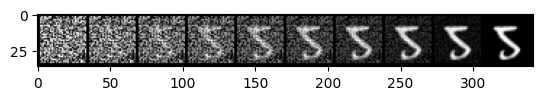

In [4]:
def noiser(img, steps):
    noise = torch.rand_like(img)
    noise_scale = lambda s: 1 - (s / (steps-1))
    noisy_imgs = [
        img * (1 - noise_scale(s)) + noise * noise_scale(s) for s in range(steps)
    ]
    return noisy_imgs

x, y = next(iter(train_loader))
imgs = noiser(x[0], 10)
grid = torchvision.utils.make_grid(imgs, nrow=10)
plt.imshow(grid.permute(1, 2, 0))
plt.show()


In [5]:
def generate(model, noise, steps, y=None):
    model.eval()
    if y is None:
        y = torch.randint(0, 10, (noise.size(0),), device=noise.device)

    with torch.no_grad():
        for t in range(steps):            
            noise = model(
                noise,
                torch.as_tensor(y, device=device),
                torch.as_tensor(torch.full_like(y, t), device=device),
            )

    return noise


In [6]:
def plot(train_loader, model, steps):
    with torch.no_grad():
        plt.figure(figsize=(20, 3))
        
        x, y = next(iter(train_loader))
        x, y = x.to(device), y.to(device)
        noise = torch.rand_like(x)
        
        generated = generate(model, noise, steps, y)
        plt.figure(figsize=(10, 5))
        grid = torchvision.utils.make_grid(generated, nrow=16).cpu()
        plt.imshow(grid.permute(1, 2, 0))
        plt.title("Generated")
        plt.axis('off')
        plt.show()


In [7]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_channels, out_channels, kernel_size=3, padding=1, bias=False
        )
        self.norm1 = nn.GroupNorm(1, out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(
            out_channels, out_channels, kernel_size=3, padding=1, bias=False
        )
        self.norm2 = nn.GroupNorm(1, out_channels)

        if in_channels != out_channels:
            self.residual_conv = nn.Conv2d(
                in_channels, out_channels, kernel_size=1, bias=False
            )

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.norm1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.norm2(out)
        if x.shape != out.shape:
            residual = self.residual_conv(x)
        out += residual
        out = self.relu(out)
        return out


class Model(nn.Module):
    def __init__(self, num_classes=10, embed_dim=4):
        super(Model, self).__init__()
        # Downsampling path
        self.num_classes = num_classes
        self.embed_dim = embed_dim

        # Embeddings
        self.time_embedding = nn.Embedding(10, embed_dim)
        self.class_embedding = nn.Embedding(num_classes, embed_dim)

        # Initial convolution
        self.initial_conv = nn.Conv2d(1, 4, kernel_size=3, padding=1)

        # Adjusted for concatenated embeddings: 4 + 16 (t_emb) + 16 (y_emb) = 36 input channels
        self.down1 = ResidualBlock(12, 16)  # (12, 32, 32) -> (32, 16, 16)

        self.down2 = ResidualBlock(16, 32)  # (32, 16, 16) -> (64, 8, 8)
        self.down3 = ResidualBlock(32, 64)  # (64, 8, 8) -> (128, 4, 4)
        
        self.bottleneck = ResidualBlock(64, 64)  # Bottleneck (128, 4, 4) -> (128, 4, 4)
        
        self.up3 = nn.Sequential(
            nn.Upsample(scale_factor=2, mode="nearest"), ResidualBlock(64, 32)
        ) # (128, 4, 4) -> (64, 8, 8)
        self.up2 = nn.Sequential(
            nn.Upsample(scale_factor=2, mode="nearest"), ResidualBlock(32, 16)
        )  # (64, 8, 8) -> (32, 16, 16)
        self.up1 = nn.Sequential(
            nn.Upsample(scale_factor=2, mode="nearest"), ResidualBlock(16, 4)
        )  # (32, 16, 16) -> (4, 32, 32)
        self.final_conv = nn.Conv2d(4, 1, kernel_size=1)

    def forward(self, x, y, t):
        # Embeddings for timestep and class
        t_emb = self.time_embedding(t).view(-1, self.embed_dim, 1, 1)
        y_emb = self.class_embedding(y).view(-1, self.embed_dim, 1, 1)

        # Initial convolution
        x = self.initial_conv(x)

        # Concatenate embeddings with feature maps
        t_emb_expanded = t_emb.expand(-1, -1, x.size(2), x.size(3))
        y_emb_expanded = y_emb.expand(-1, -1, x.size(2), x.size(3))
        x = torch.cat(
            [x, t_emb_expanded, y_emb_expanded], dim=1
        )  # Concatenation should work now

        # Continue as before
        d1 = F.max_pool2d(F.gelu(self.down1(x)), 2)
        d2 = F.max_pool2d(F.gelu(self.down2(d1)), 2)
        d3 = F.max_pool2d(F.gelu(self.down3(d2)), 2)
        b = F.gelu(self.bottleneck(d3))
        u3 = F.gelu(self.up3(b))
        u2 = F.gelu(self.up2(u3 + d2))
        u1 = F.gelu(self.up1(u2 + d1))
        out = F.sigmoid(self.final_conv(u1))
        return out


# Example usage
model = Model()

# Save as ONNX
dummy_input = torch.randn(1, 1, 32, 32)
torch.onnx.export(
    model,
    (dummy_input, torch.tensor([0]), torch.tensor([0])),
    "model.onnx",
    verbose=False,
    input_names=["input", "class", "time"],
    output_names=["output"],
)

model = model.to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

stats = {
    "train_loss": [],
    "test_loss": [],
    "test_accuracy": [],
}

print(f"Model has {sum(p.numel() for p in model.parameters()):,} parameters")
print(
    f"Model uses RAM: {sum(p.numel() * p.element_size() for p in model.parameters()) / 1024 / 1024:.2f} MB"
)


/var/folders/dt/jzfvrb8n4rd4cfvmp380lx000000gn/T/ipykernel_1692/512692584.py:26: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if x.shape != out.shape:


Model has 188,573 parameters
Model uses RAM: 0.72 MB


In [8]:
optimizer = optim.Adam(model.parameters(), lr=1e-3)


Train :: Epoch: 0/10:   1%|          | 10/938 [00:35<54:40,  3.54s/it, Loss: 0.5198]

<Figure size 2000x300 with 0 Axes>

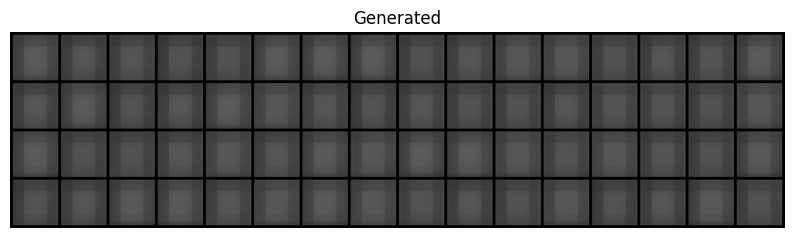

Train :: Epoch: 0/10:   2%|▏         | 20/938 [01:12<54:11,  3.54s/it, Loss: 0.3990]  

<Figure size 2000x300 with 0 Axes>

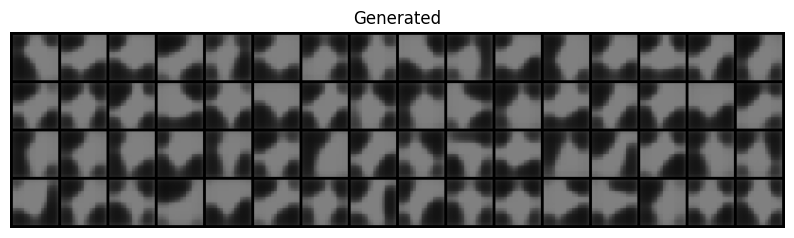

Train :: Epoch: 0/10:   3%|▎         | 30/938 [01:49<53:54,  3.56s/it, Loss: 0.3235]  

<Figure size 2000x300 with 0 Axes>

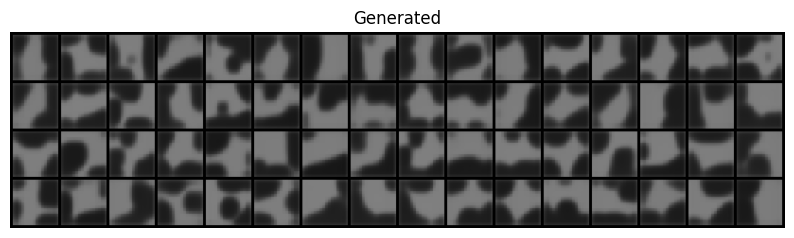

Train :: Epoch: 0/10:   4%|▍         | 40/938 [02:27<54:50,  3.66s/it, Loss: 0.2897]  

<Figure size 2000x300 with 0 Axes>

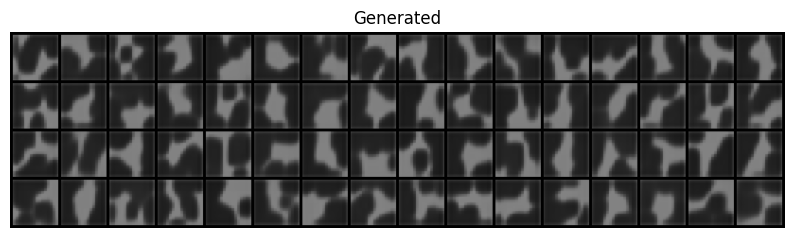

Train :: Epoch: 0/10:   5%|▌         | 50/938 [03:03<52:35,  3.55s/it, Loss: 0.2791]  

<Figure size 2000x300 with 0 Axes>

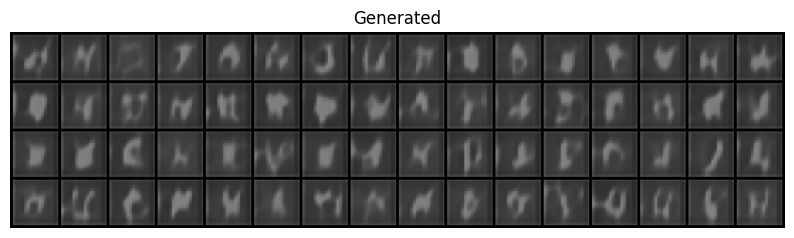

Train :: Epoch: 0/10:   6%|▋         | 60/938 [03:40<52:08,  3.56s/it, Loss: 0.2656]

<Figure size 2000x300 with 0 Axes>

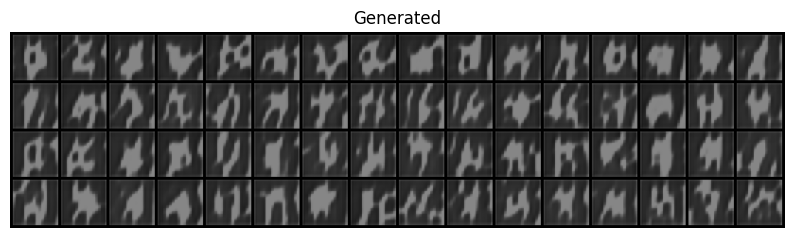

Train :: Epoch: 0/10:   7%|▋         | 70/938 [04:17<51:48,  3.58s/it, Loss: 0.2487]

<Figure size 2000x300 with 0 Axes>

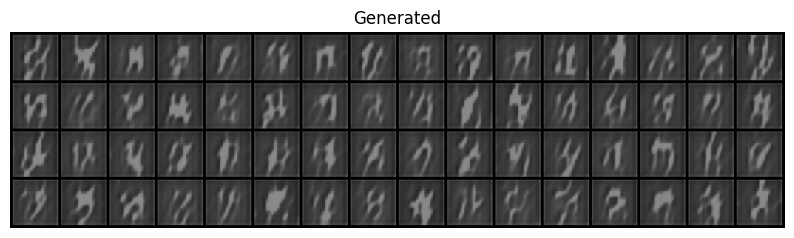

Train :: Epoch: 0/10:   9%|▊         | 80/938 [10:19<54:19,  3.80s/it, Loss: 0.2265]

<Figure size 2000x300 with 0 Axes>

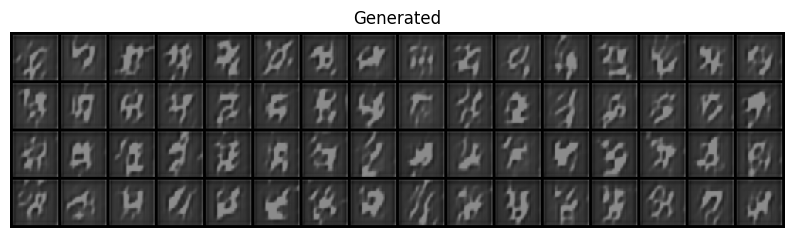

Train :: Epoch: 0/10:  10%|▉         | 90/938 [27:31<9:48:46, 41.66s/it, Loss: 0.2081]  

<Figure size 2000x300 with 0 Axes>

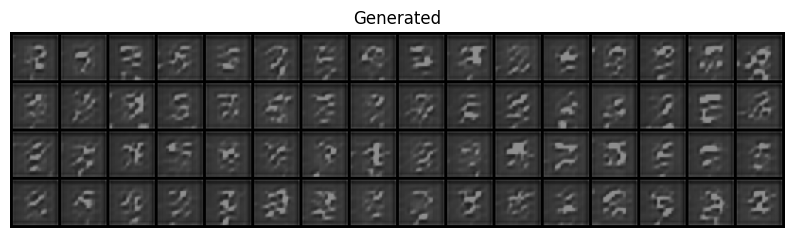

Train :: Epoch: 0/10:  11%|█         | 100/938 [1:18:08<38:25:18, 165.06s/it, Loss: 0.2074]

<Figure size 2000x300 with 0 Axes>

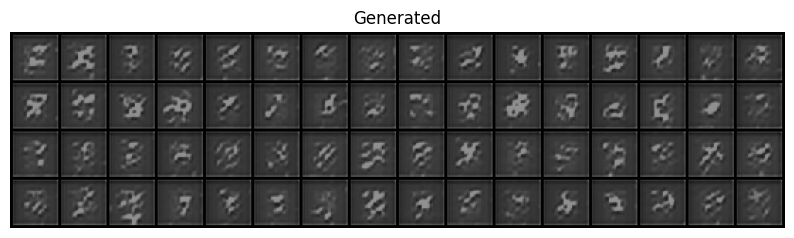

Train :: Epoch: 0/10:  12%|█▏        | 110/938 [1:24:31<11:30:45, 50.05s/it, Loss: 0.1906] 

<Figure size 2000x300 with 0 Axes>

Train :: Epoch: 0/10:  12%|█▏        | 110/938 [1:24:32<10:36:25, 46.12s/it, Loss: 0.1906]


KeyboardInterrupt: 

In [9]:
model = model.to(device)
for epoch in range(10):
    model.train()

    with tqdm.tqdm(total=len(train_loader), dynamic_ncols=True) as tq:
        tq.set_description(f"Train :: Epoch: {epoch}/{10}")

        for x, y in train_loader:
            tq.update(1)
            x, y = x.to(device), y.to(device)
            total_loss = 0

            noisy_imgs = noiser(x, 10)
            
            for t, (sample, target) in enumerate(zip(noisy_imgs, noisy_imgs[1:])):
                optimizer.zero_grad()
                pred = model(
                    sample,
                    torch.as_tensor(y, device=device),
                    torch.as_tensor(torch.full_like(y, t), device=device),
                )
                loss = criterion(pred, target)

                loss.backward()
                optimizer.step()

                total_loss += loss.item()

            tq.set_postfix_str(f"Loss: {total_loss:.4f}")

        
            if tq.n % 10 == 0:
                model.eval()
                plot(train_loader, model, 10)


In [ ]:
plot(train_loader, model, 8)


In [ ]:
noise = torch.rand(512, 1, 28, 28, device = device)
generated = generate(model, noise, 10)
grid = torchvision.utils.make_grid(generated, nrow=32).cpu()

plt.figure(figsize=(20, 20))
plt.imshow(grid.permute(1, 2, 0))
plt.title("Random")
plt.axis('off')
plt.show()
